<img src="https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/courses/2021-11-vu-ml-reasoning/vu.jpg?raw=1" alt="Logo" width=128px/>

<img src="https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/img/logo_amds.png?raw=1" alt="Logo" width=128px/>

# Machine Learning and Reasoning for Health - Vrije Universiteit Amsterdam
## AmsterdamUMCdb - Freely Accessible ICU Database

AmsterdamUMCdb version 1.0.2 March 2020  
Copyright &copy; 2003-2021 Amsterdam UMC - Amsterdam Medical Data Science

In [1]:
#sets the project id
PROJECT_ID = "gentle-bearing-330917" #@param {type:"string"}

## Access AmsterdamUMCdb

In [2]:
import os
from google.colab import auth
 
#sets dateset
DATASET_PROJECT_ID = 'amsterdamumcdb'
DATASET_ID = 'version1_0_2'
LOCATION = 'eu'
 
#all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
 
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
%load_ext google.colab.data_table

In [4]:
from google.cloud.bigquery import magics
from google.cloud import bigquery

#sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)
magics.context.default_query_job_config = def_config

#sets client options job configuration
client_options = {}
client_options['location'] = LOCATION
magics.context.bigquery_client_options = client_options

In [5]:
from google.cloud import bigquery

#BigQuery requires a separate config to prevent the 'BadRequest: 400 Cannot explicitly modify anonymous table' error message
job_config = bigquery.job.QueryJobConfig()

#sets default client settings by re-using the previously defined config
client = bigquery.Client(project=PROJECT_ID, location=LOCATION, default_query_job_config=def_config)

In [6]:
import pandas as pd

config_gbq = {'query': 
          {'defaultDataset': {
              "datasetId": DATASET_ID, 
              "projectId": DATASET_PROJECT_ID
              },
           'Location': LOCATION}
           }

In [7]:
#get the amsterdamumcdb package from PiPy repository for use in Colab
!pip install amsterdamumcdb
import amsterdamumcdb as adb

     |████████████████████████████████| 199 kB 4.8 MB/s 


In [8]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/MLRFH')

Mounted at /content/drive


## Data Extraction

In [10]:
# data = pd.read_gbq(
#     '''
#     WITH sepsis AS (
#       SELECT 
#     l.admissionid
# FROM listitems_validated l
# LEFT JOIN admissions a ON
#         l.admissionid = a.admissionid
#  WHERE 
#     (
#         l.itemid = 15808  --Opname Sepsis
#         AND (l.itemid = 16675  --DMC_Opname Sepsis
#         )
#         AND (l.value = 'Ja'))
# GROUP BY l.admissionid
# ),
# action AS (    SELECT
#         d.admissionid
#     FROM drugitems d
#     LEFT JOIN admissions a ON
#         d.admissionid = a.admissionid
#     WHERE 
#         d.ordercategoryid = 55 
#         AND d.itemid IN (
#             7229, -- Noradrenaline (Norepinefrine)
#             7291  -- Crystalloid (fluid)
#         )
#         GROUP BY d.admissionid
#     ),
#   state as (
#     SELECT n.admissionid,
#     FROM numericitems_validated n
#     LEFT JOIN admissions a ON
#         n.admissionid = a.admissionid
#     WHERE n.itemid IN (
#     9941,  --Kreatinine (blood)
#     8794,  --UrineCAD
#     6642,  --ABP Mean Blood Pressure
#     9924,  --Natrium in blood
#     9927,  --Kalium in blood
#     6836  --Kreatinine
#     , 8796  --UrineSupraPubis
#     , 8798 --UrineSpontaan
#     , 8800 --UrineIncontinentie
#     , 8803 --UrineUP
#     , 10743 --Nefrodrain li Uit
#     , 10745 --Nefrodrain re Uit
#         ) 
#       GROUP BY n.admissionid
#   )
#   SELECT 
#     n.admissionid,
#     n.itemid,
#     n.item,
#     n.value,
#     n.registeredby,
#     n.measuredat,
#     (n.measuredat - a.admittedat) AS time,
#     a.weightgroup,
#     a.heightgroup,
#     a.gender,
#     a.agegroup,
#     FROM numericitems_validated n
#     LEFT JOIN admissions a ON
#     n.admissionid = a.admissionid
#     LEFT JOIN sepsis s ON
#     n.admissionid = s.admissionid
#     LEFT JOIN action v ON
#     n.admissionid = v.admissionid
#     LEFT JOIN state r ON 
#     n.admissionid = r.admissionid
#     WHERE n.itemid IN (
#     9941,  --Kreatinine (blood)
#     8794,  --UrineCAD
#     6642,  --ABP Mean Blood Pressure
#     9924,  --Natrium in blood
#     9927,  --Kalium in blood
#     6836  --Kreatinine
#     , 8796  --UrineSupraPubis
#     , 8798 --UrineSpontaan
#     , 8800 --UrineIncontinentie
#     , 8803 --UrineUP
#     , 10743 --Nefrodrain li Uit
#     , 10745 --Nefrodrain re Uit
#     ) 
#     '''
#     , configuration=config_gbq)

In [11]:
# action_space = pd.read_gbq(
#     '''
#     WITH MV AS (
#       SELECT 
#     l.admissionid,
# FROM listitems_validated l
# LEFT JOIN admissions a ON
#         l.admissionid = a.admissionid
#  WHERE 
#     (
#         l.itemid = 15808  --Opname Sepsis
#         AND (l.itemid = 16675  --DMC_Opname Sepsis
#         )
#         AND (l.value = 'Ja'))
#       GROUP BY l.admissionid
# ),
# VASOP AS (    SELECT
#     d.admissionid
#     FROM drugitems d
#     LEFT JOIN listitems_validated l ON
#         d.admissionid = l.admissionid
#     WHERE (
#         d.ordercategoryid = 55 -- continuous i.v. perfusor
#         AND d.itemid IN (
#             7229, -- Noradrenaline (Norepinefrine)
#             7291  -- Crystalloid (fluid)
#         ) AND l.itemid  IN ( 
#           15808,  --Opname Sepsis
#           16675  --DMC_Opname Sepsis
#         )
#         AND (l.value = 'Ja')
#         ) 
#         GROUP BY admissionid
#     ),
#   RRT as (
#     SELECT n.admissionid,
#     CASE
#         WHEN COUNT(*) > 0 THEN TRUE
#         ELSE FALSE
#     END AS renal_replacement_bool,
#     FROM numericitems_validated n
#     LEFT JOIN admissions a ON
#         n.admissionid = a.admissionid
#     WHERE n.itemid IN (
#             10736, --Bloed-flow
#             12460, --Bloedflow
#             14850 --MFT_Bloedflow (ingesteld): Fresenius multiFiltrate blood flow
#         ) 
#       GROUP BY n.admissionid
# ),
# baseline AS (
#       SELECT n.admissionid,
#       MIN(n.value) AS baseline_creatinine
#       FROM numericitems_validated n
#       LEFT JOIN admissions a ON
#         n.admissionid = a.admissionid
#       WHERE itemid IN (
#         6836, --Kreatinine µmol/l (erroneously documented as µmol)
#         9941, --Kreatinine (bloed) µmol/l
#         14216 --KREAT enzym. (bloed) µmol/l
#       )
#       GROUP BY n.admissionid
#     )
#   SELECT 
#     dr.admissionid,
#     dr.itemid,
#     dr.item,
#     dr.start, 
#     dr.stop,
#     dr.administered,
#     a.weightgroup,
#     a.heightgroup,
#     a.gender,
#     a.agegroup
#     FROM drugitems dr
#     LEFT JOIN admissions a ON
#     dr.admissionid = a.admissionid
#     LEFT JOIN MV m ON
#     dr.admissionid = m.admissionid
#     LEFT JOIN VASOP v ON
#     dr.admissionid = v.admissionid
#     LEFT JOIN RRT r ON 
#     dr.admissionid = r.admissionid
#     LEFT JOIN baseline b ON
#     dr.admissionid = b.admissionid
#     WHERE dr.itemid IN (
#         7229, -- Noradrenaline (Norepinefrine)
#         7291  -- Crystalloid (fluid)
#     )
#     '''
#     , configuration=config_gbq)

In [12]:
# action_space.to_csv('action_space.csv')

## Saving/Loading the Dataset

In [15]:
space = pd.read_csv('space_correct_demo7.csv')

## Visualization

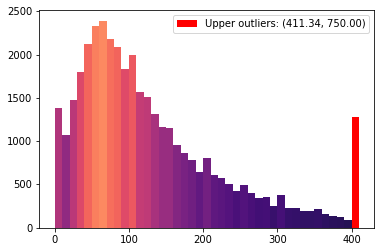

In [17]:
urine = space['UrineCAD']
adb.outliers_histogram(data=urine).show()

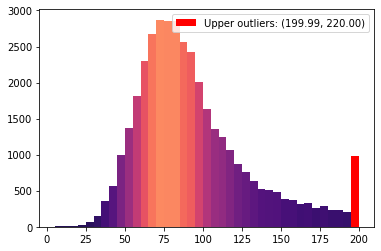

In [18]:
kreat = space['Kreatinine (bloed)']
adb.outliers_histogram(data=kreat).show()

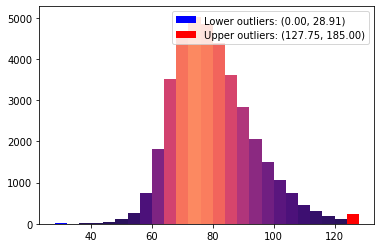

In [19]:
blood = space['ABP gemiddeld']
adb.outliers_histogram(data=blood).show()

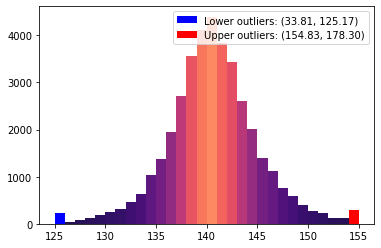

In [20]:
natrium = space['Natrium (bloed)']
adb.outliers_histogram(data=natrium, ).show()

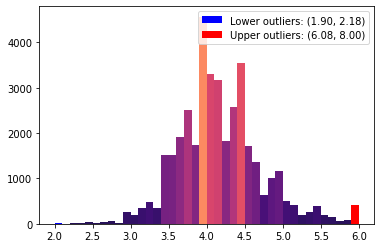

In [21]:
kalium = space['Kalium (bloed)']
adb.outliers_histogram(data=kalium).show()

## Clustering

In [22]:
import matplotlib.colors as cl
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from scipy.cluster.hierarchy import dendrogram
import itertools
from scipy.optimize import curve_fit
import re
import math
import sys
from pathlib import Path
import dateutil

class VisualizeDataset:

    point_displays = ['+', 'x'] #'*', 'd', 'o', 's', '<', '>']
    line_displays = ['-'] #, '--', ':', '-.']
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    # Set some initial attributes to define and create a save location for the images.
    def __init__(self):
        pass

    # Plot the dataset, here columns can specify a specific attribute, but also a generic name that occurs
    # among multiple attributes (e.g. label which occurs as labelWalking, etc). In such a case they are plotted
    # in the same graph. The display should express whether points or a line should be plotted.
    # Match can be 'exact' or 'like'. Display can be 'points' or 'line'.
    def plot_dataset(self, data_table, columns, match='like', display='line'):
        names = list(data_table.columns)

        # Create subplots if more columns are specified.
        if len(columns) > 1:
            f, xar = plt.subplots(len(columns), sharex=True, sharey=False)
        else:
            f, xar = plt.subplots()
            xar = [xar]

        f.subplots_adjust(hspace=0.4)

        xfmt = md.DateFormatter('%H:%M')

        # Pass through the columns specified.
        for i in range(0, len(columns)):
            xar[i].xaxis.set_major_formatter(xfmt)
            xar[i].set_prop_cycle(color=['b', 'g', 'r', 'c', 'm', 'y', 'k'])
            # if a column match is specified as 'exact', select the column name(s) with an exact match.
            # If it's specified as 'like', select columns containing the name.

            # We can match exact (i.e. a columns name is an exact name of a columns or 'like' for
            # which we need to find columns names in the dataset that contain the name.
            if match[i] == 'exact':
                relevant_cols = [columns[i]]
            elif match[i] == 'like':
                relevant_cols = [name for name in names if columns[i] == name[0:len(columns[i])]]
            else:
                raise ValueError("Match should be 'exact' or 'like' for " + str(i) + ".")

            max_values = []
            min_values = []



            # Pass through the relevant columns.
            for j in range(0, len(relevant_cols)):
                # Create a mask to ignore the NaN and Inf values when plotting:
                mask = data_table[relevant_cols[j]].replace([np.inf, -np.inf], np.nan).notnull()
                max_values.append(data_table[relevant_cols[j]][mask].max())
                min_values.append(data_table[relevant_cols[j]][mask].min())

                # Display point, or as a line
                if display[i] == 'points':
                    xar[i].plot(data_table.index[mask], data_table[relevant_cols[j]][mask],
                                self.point_displays[j%len(self.point_displays)])
                else:
                    xar[i].plot(data_table.index[mask], data_table[relevant_cols[j]][mask],
                                self.line_displays[j%len(self.line_displays)])

            xar[i].tick_params(axis='y', labelsize=10)
            xar[i].legend(relevant_cols, fontsize='xx-small', numpoints=1, loc='upper center',
                          bbox_to_anchor=(0.5, 1.3), ncol=len(relevant_cols), fancybox=True, shadow=True)

            xar[i].set_ylim([min(min_values) - 0.1*(max(max_values) - min(min_values)),
                             max(max_values) + 0.1*(max(max_values) - min(min_values))])

        # Make sure we get a nice figure with only a single x-axis and labels there.
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
        plt.xlabel('time')
        self.save(plt)
        plt.show()

    def plot_xy(self, x, y, method='plot', xlabel=None, ylabel=None, xlim=None, ylim=None, names=None,
                line_styles=None, loc=None, title=None):
        for input in x, y:
            if not hasattr(input[0], '__iter__'):
                raise TypeError('x/y should be given as a list of lists of coordinates')

        plot_method = getattr(plt, method)
        for i, (x_line, y_line) in enumerate(zip(x, y)):

            plot_method(x_line, y_line, line_styles[i]) if line_styles is not None else plt.plot(x_line, y_line)

            if xlabel is not None: plt.xlabel(xlabel)
            if ylabel is not None: plt.ylabel(ylabel)
            if xlim is not None: plt.xlim(xlim)
            if ylim is not None: plt.ylim(ylim)
            if title is not None: plt.title(title)
            if names is not None: plt.legend(names)

        self.save(plt)
        plt.show()

    def plot_dataset_boxplot(self, dataset, cols):
        plt.Figure(); dataset[cols].plot.box()
        plt.ylim([-30,30])
        self.save(plt)
        plt.show()

    # This function plots the real and imaginary amplitudes of the frequencies found in the Fourier transformation.
    def plot_fourier_amplitudes(self, freq, ampl_real, ampl_imag):
        plt.xlabel('Freq(Hz)')
        plt.ylabel('amplitude')
        # Plot the real values as a '+' and imaginary in the same way (though with a different color).
        plt.plot(freq, ampl_real, '+', freq, ampl_imag,'+')
        plt.legend(['real', 'imaginary'], numpoints=1)
        self.save(plt)
        plt.show()

    # Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    # column and outlier_col the columns with a binary value (outlier or not)
    def plot_binary_outliers(self, data_table, col, outlier_col):
        data_table.loc[:,:] = data_table.dropna(axis=0, subset=[col, outlier_col])
        data_table.loc[:,outlier_col] = data_table[outlier_col].astype('bool')
        f, xar = plt.subplots()
        xfmt = md.DateFormatter('%H:%M')
        xar.xaxis.set_major_formatter(xfmt)
        plt.xlabel('time')
        plt.ylabel('value')
        # Plot data points that are outliers in red, and non outliers in blue.
        xar.plot(data_table.index[data_table[outlier_col]], data_table[col][data_table[outlier_col]], 'r+')
        xar.plot(data_table.index[~data_table[outlier_col]], data_table[col][~data_table[outlier_col]], 'b+')
        plt.legend(['outlier ' + col, 'no_outlier_' + col], numpoints=1, fontsize='xx-small', loc='upper center',  ncol=2, fancybox=True, shadow=True)
        self.save(plt)
        plt.show()

    # Plot values that have been imputed using one of our imputation approaches. Here, values expresses the
    # 1 to n datasets that have resulted from value imputation.
    def plot_imputed_values(self, data_table, names, col, *values):

        xfmt = md.DateFormatter('%H:%M')

        # Create proper subplots.
        if len(values) > 0:
            f, xar = plt.subplots(len(values) + 1, sharex=True, sharey=False)
        else:
            f, xar = plt.subplots()
            xar = [xar]

        f.subplots_adjust(hspace=0.4)

        # plot the regular dataset.

        xar[0].xaxis.set_major_formatter(xfmt)
        xar[0].plot(data_table.index[data_table[col].notnull()], data_table[col][data_table[col].notnull()], 'b+', markersize='2')
        xar[0].legend([names[0]], fontsize='small', numpoints=1, loc='upper center',  bbox_to_anchor=(0.5, 1.3), ncol=1, fancybox=True, shadow=True)

        # and plot the others that have resulted from imputation.
        for i in range(1, len(values)+1):
            xar[i].xaxis.set_major_formatter(xfmt)
            xar[i].plot(data_table.index, values[i-1], 'b+', markersize='2')
            xar[i].legend([names[i]], fontsize='small', numpoints=1, loc='upper center',  bbox_to_anchor=(0.5, 1.3), ncol=1, fancybox=True, shadow=True)

        # Diplay is nicely in subplots.
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
        plt.xlabel('time')
        self.save(plt)
        plt.show()

    # This function plots clusters that result from the application of a clustering algorithm
    # and also shows the class label of points. Clusters are displayed via colors, classes
    # by means of different types of points. We assume that three data columns are clustered
    # that do not include the label. We assume the labels to be represented by 1 or more binary
    # columns.
    def plot_clusters_3d(self, data_table, data_cols, cluster_col, label_cols):

        color_index = 0
        point_displays = ['+', 'x', '*', 'd', 'o', 's', '<', '>']

        # Determine the number of clusters:
        clusters = data_table[cluster_col].unique()
        labels = []

        # Get the possible labels, assuming 1 or more label columns with binary values.
        for i in range(0, len(label_cols)):
            labels.extend([name for name in list(data_table.columns) if label_cols[i] == name[0:len(label_cols[i])]])

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        handles = []

        # Plot clusters individually with a certain color.
        for cluster in clusters:
            marker_index = 0
            # And make sure the points of a label receive the right marker type.
            for label in labels:
                rows = data_table.loc[(data_table[cluster_col] == cluster) & (data_table[label] > 0)]
                # Now we come to the assumption that there are three data_cols specified:
                if not len(data_cols) == 3:
                    return
                plot_color = self.colors[color_index%len(self.colors)]
                plot_marker = point_displays[marker_index%len(point_displays)]
                pt = ax.scatter(rows[data_cols[0]], rows[data_cols[1]], rows[data_cols[2]], c=plot_color, marker=plot_marker)
                if color_index == 0:
                    handles.append(pt)
                ax.set_xlabel(data_cols[0])
                ax.set_ylabel(data_cols[1])
                ax.set_zlabel(data_cols[2])
                marker_index += 1
            color_index += 1

        plt.legend(handles, labels, fontsize='xx-small', numpoints=1)
        self.save(plt)
        plt.show()

    # This function plots the silhouettes of the different clusters that have been identified. It plots the
    # silhouette of the individual datapoints per cluster to allow studying the clusters internally as well.
    # For this, a column expressing the silhouette for each datapoint is assumed.
    def plot_silhouette(self, data_table, cluster_col, silhouette_col):
        # Taken from the examples of scikit learn
        #(http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

        clusters = data_table[cluster_col].unique()

        fig, ax1 = plt.subplots(1, 1)
        ax1.set_xlim([-0.1, 1])
        #ax1.set_ylim([0, len(data_table.index) + (len(clusters) + 1) * 10])
        y_lower = 10
        for i in range(0, len(clusters)):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            rows = data_table.mask(data_table[cluster_col] == clusters[i])
            ith_cluster_silhouette_values = np.array(rows[silhouette_col])
            ith_cluster_silhouette_values.sort()

            size_cluster_i = len(rows.index)
            y_upper = y_lower + size_cluster_i

            color = plt.get_cmap('Spectral')(float(i) / len(clusters))
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=data_table[silhouette_col].mean(), color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        self.save(plt)
        plt.show()

    # Plot a dendorgram for hierarchical clustering. It assumes that the linkage as
    # used in sk learn is passed as an argument as well.
    def plot_dendrogram(self, dataset, linkage):
        sys.setrecursionlimit(40000)
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('time points')
        plt.ylabel('distance')
        times = dataset.index.strftime('%H:%M:%S')
        #dendrogram(linkage,truncate_mode='lastp',p=10, show_leaf_counts=True, leaf_rotation=90.,leaf_font_size=12.,show_contracted=True, labels=times)
        dendrogram(linkage,truncate_mode='lastp',p=16, show_leaf_counts=True, leaf_rotation=45.,leaf_font_size=8.,show_contracted=True, labels=times)
        self.save(plt)
        plt.show()

    # Plot the confusion matrix that has been derived in the evaluation metrics. Classes expresses the labels
    # for the matrix. We can normalize or show the raw counts. Of course this applies to classification problems.
    def plot_confusion_matrix(self, cm, classes, normalize=False):
        # Taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

        # Select the colormap.
        cmap=plt.cm.Blues
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title('confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        self.save(plt)
        plt.show()

    # This function plots the predictions or an algorithms (both for the training and test set) versus the real values for
    # a regression problem. It assumes only a single value to be predicted over a number of cases. The variables identified
    # with reg_ are the predictions.
    def plot_numerical_prediction_versus_real(self, train_time, train_y, regr_train_y, test_time, test_y, regr_test_y, label):
        self.legends = {}

        # Plot the values, training set cases in blue, test set in red.
        f, xar = plt.subplots(1, 1)

        xfmt = md.DateFormatter('%H:%M')
        xar.xaxis.set_major_formatter(xfmt)
        xar.set_prop_cycle(color=['b', 'g', 'r', 'c', 'm', 'y', 'k'])
        plt.plot(train_time, train_y, '-', linewidth=0.5)
        plt.plot(train_time, regr_train_y, '--', linewidth=0.5)

        plt.plot(test_time, test_y, '-', linewidth=0.5)
        plt.plot(test_time, regr_test_y, '--', linewidth=0.5)

        plt.legend(['real values training', 'predicted values training', 'real values test', 'predicted values test'], loc=4)


        # And create some fancy stuff in the figure to label the training and test set a bit clearer.
        max_y_value = max(max(train_y.tolist()), max(regr_train_y.tolist()), max(test_y.tolist()), max(regr_test_y.tolist()))
        min_y_value = min(min(train_y.tolist()), min(regr_train_y.tolist()), min(test_y.tolist()), min(regr_test_y.tolist()))
        range = max_y_value - min_y_value
        y_coord_labels = max(max(train_y.tolist()), max(regr_train_y.tolist()), max(test_y.tolist()), max(regr_test_y.tolist()))+(0.01*range)


        plt.title('Performance of model for ' + str(label))
        plt.ylabel(label)
        plt.xlabel('time')
        plt.annotate('', xy=(train_time[0],y_coord_labels), xycoords='data', xytext=(train_time[-1], y_coord_labels), textcoords='data', arrowprops={'arrowstyle': '<->'})
        plt.annotate('training set', xy=(train_time[int(float(len(train_time))/2)], y_coord_labels*1.02), color='blue', xycoords='data', ha='center')
        plt.annotate('', xy=(test_time[0], y_coord_labels), xycoords='data', xytext=(test_time[-1], y_coord_labels), textcoords='data', arrowprops={'arrowstyle': '<->'})
        plt.annotate('test set', xy=(test_time[int(float(len(test_time))/2)], y_coord_labels*1.02), color='red', xycoords='data', ha='center')
        self.save(plt)
        plt.show()

    # Plot the Pareto front for multi objective optimization problems (for the dynamical systems stuff). We consider the
    # raw output of the MO dynamical systems approach, which includes rows with the fitness and predictions for the training
    # and test set. We select the fitness and plot them in a graph. Note that the plot only considers the first two dimensions.
    def plot_pareto_front(self, dynsys_output):
        fit_1_train = []
        fit_2_train = []
        fit_1_test = []
        fit_2_test = []
        for row in dynsys_output:
            fit_1_train.append(row[1][0])
            fit_2_train.append(row[1][1])

        plt.scatter(fit_1_train, fit_2_train, color='r')
        plt.xlabel('mse on ' + str(dynsys_output[0][0].columns[0]))
        plt.ylabel('mse on ' + str(dynsys_output[0][0].columns[1]))
        #plt.savefig('{0} Example ({1}).pdf'.format(ea.__class__.__name__, problem.__class__.__name__), format='pdf')
        self.save(plt)
        plt.show()

    # Plot a prediction for a regression model in case it concerns a multi-objective dynamical systems model. Here, we plot
    # the individual specified. Again, the complete output of the MO approach is used as argument.
    def plot_numerical_prediction_versus_real_dynsys_mo(self, train_time, train_y, test_time, test_y, dynsys_output, individual, label):
        regr_train_y = dynsys_output[individual][0][label]
        regr_test_y = dynsys_output[individual][2][label]
        train_y = train_y[label]
        test_y = test_y[label]
        self.plot_numerical_prediction_versus_real(train_time, train_y, regr_train_y, test_time, test_y, regr_test_y, label)

    # Visualizes the performance of different algorithms over different feature sets. Assumes the scores to contain
    # a score on the training set followed by an sd, and the same for the test set.
    def plot_performances(self, algs, feature_subset_names, scores_over_all_algs, ylim, std_mult, y_name):

        width = float(1)/(len(feature_subset_names)+1)
        ind = np.arange(len(algs))
        for i in range(0, len(feature_subset_names)):
            means = []
            std = []
            for j in range(0, len(algs)):
                means.append(scores_over_all_algs[i][j][2])
                std.append(std_mult * scores_over_all_algs[i][j][3])
            plt.errorbar(ind + i * width, means, yerr=std, fmt=self.colors[i%len(self.colors)] + 'o', markersize='3')
        plt.ylabel(y_name)
        plt.xticks(ind+(float(len(feature_subset_names))/2)*width, algs)
        plt.legend(feature_subset_names, loc=4, numpoints=1)
        if not ylim is None:
            plt.ylim(ylim)
        self.save(plt)
        plt.show()

    def plot_performances_classification(self, algs, feature_subset_names, scores_over_all_algs):
        self.plot_performances(algs, feature_subset_names, scores_over_all_algs, [0.70, 1.0], 2, 'Accuracy')

    def plot_performances_regression(self, algs, feature_subset_names, scores_over_all_algs):
        self.plot_performances(algs, feature_subset_names, scores_over_all_algs, None, 1, 'Mean Squared Error')

In [23]:
##############################################################
#                                                            #
#    Mark Hoogendoorn and Burkhardt Funk (2017)              #
#    Machine Learning for the Quantified Self                #
#    Springer                                                #
#    Chapter 5                                               #
#                                                            #
##############################################################

import math
import numbers
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
import sys
from sklearn.neighbors import DistanceMetric
import sklearn



# Class defining the distance metrics that are not available as standard ones....
class InstanceDistanceMetrics:

    # S for gowers distance
    def s(self, val1, val2, range):
        # If we compare numbers we look at the difference and normalize.
        if isinstance(val1, numbers.Number) and isinstance(val1, numbers.Number):
            return 1 - (float(abs(val1-val2))/range)
        # If we compare something else, we just look at whether they are equal.
        else:
            if val1 == val2:
                return 1
            else:
                return 0

    # Delta for gowers distance.
    def delta(self, val1, val2):
        # Check whether both values are known (i.e. nan), if so the delta is 1, 0 otherwise.
        if (not np.isnan(val1)) and (not np.isnan(val2)):
            return 1
        return 0

    # Define gowers distance between two rows, given the ranges of the variables
    # over the entire dataset (over all columns in row1 and row2)
    def gower_similarity(self, data_row1, data_row2, ranges):
        # We cannot computer if the lengths are not equal.
        if len(data_row1.columns) != len(data_row2.columns):
            return -1

        delta_total = 0
        s_total = 0

        # iterate over all columns.
        for i in range(0, len(data_row1.columns)):
            val1 = data_row1[data_row1.columns[i]].values[0]
            val2 = data_row2[data_row2.columns[i]].values[0]
            # compute the delta
            delta = self.delta(val1, val2)
            delta_total = delta_total + delta
            if delta > 0:
                # and compute the s if the delta is above 0.
                s_total = s_total + self.s(val1, val2, ranges[i])
        return float(s_total)/delta_total

# Class to flatten datasets or compute the statistical difference between cases.
class PersonDistanceMetricsNoOrdering:

    gower = 'gower'
    minkowski = 'minkowski'

    # This returns a dataset with aggregated data instances based on the mean values
    # in the rows.
    def create_instances_mean(self, datasets):
        index = range(0, len(datasets))
        cols = datasets[0].columns
        new_dataset = pd.DataFrame(index=index, columns=cols)

        for i in range(0, len(datasets)):
            for col in cols:
                # Compute the mean per column and assign that
                # value for the row representing the current
                # dataset.
                new_dataset.iloc[i, new_dataset.columns.get_loc(col)] = datasets[i][col].mean()

        return new_dataset

    # Fit datasets to normal distribution and use parameters as instances
    def create_instances_normal_distribution(self, datasets):
        index = range(0, len(datasets))
        cols = datasets[0].columns
        new_cols = []
        # Create new columns for the parameters of the distribution.
        for col in cols:
            new_cols.append(col + '_mu')
            new_cols.append(col + '_sigma')
        new_dataset = pd.DataFrame(index=index, columns=new_cols)

        for i in range(0, len(datasets)):
            for col in cols:
                # Fit the distribution and assign the values to the
                # row representing the dataset.
                mu, sigma = norm.fit(datasets[i][col])
                new_dataset.iloc[i, new_dataset.columns.get_loc(col + '_mu')] = mu
                new_dataset.iloc[i, new_dataset.columns.get_loc(col + '_sigma')] = sigma

        return new_dataset

    # This defines the distance between datasets based on the statistical
    # differences between the distribution we can only compute
    # distances pairwise.
    def p_distance(self, dataset1, dataset2):

        cols = dataset1.columns
        distance = 0
        for col in cols:
            D, p_value = stats.ks_2samp(dataset1[col], dataset2[col])
            distance= distance + (1-p_value)
        return distance

# Class to compare two time ordered datasets.
class PersonDistanceMetricsOrdering:

    extreme_value = sys.float_info.max
    tiny_value = 0.000001

    # Directly pair up the datasets and computer the euclidean
    # distances between the sequences of values.
    def euclidean_distance(self, dataset1, dataset2):
        dist = DistanceMetric.get_metric('euclidean')
        if not len(dataset1.index) == len(dataset2.index):
            return -1
        distance = 0

        for i in range(0, len(dataset1.index)):
            data_row1 = dataset1.iloc[:,i:i+1].transpose()
            data_row2 = dataset2.iloc[:,i:i+1].transpose()
            ecl_dist = dist.pairwise(data_row1, data_row2)
            distance = distance + ecl_dist

        return distance

    # Compute the distance between two datasets given a set lag.
    def lag_correlation_given_lag(self, dataset1, dataset2, lag):
        distance = 0
        for i in range(0, len(dataset1.columns)):
            # consider the lengths of the series, and compare the
            # number of points in the smallest series.
            length_ds1 = len(dataset1.index)
            length_ds2 = len(dataset2.index) - lag
            length_used = min(length_ds1, length_ds2)
            if length_used < 1:
                return self.extreme_value
            # We multiply the values as expressed in the book.
            ccc = np.multiply(dataset1.ix[0:length_used, i].values, dataset2.ix[lag:length_used+lag, i].values)
            # We add the sum of the mutliplications to the distance. Correct for the difference in length.
            distance = distance + (float(1)/(float(max(ccc.sum(), self.tiny_value))))/length_used
        return distance

    # Compute the lag correlation. For this we find the best lag.
    def lag_correlation(self, dataset1, dataset2, max_lag):
        best_dist = -1
        best_lag = 0
        for i in range(0, max_lag+1):
            # Compute the distance given a lag.
            current_dist = self.lag_correlation_given_lag(dataset1, dataset2, i)
            if current_dist < best_dist or best_dist == -1:
                best_dist = current_dist
                best_lag = i
        return best_dist

    # Simple implementation of the dtw. Note that we use the euclidean distance here..
    # The implementation follows the algorithm explained in the book very closely.
    def dynamic_time_warping(self, dataset1, dataset2):
        # Create a distance matrix between all time points.
        cheapest_path = np.full((len(dataset1.index), len(dataset2.index)), self.extreme_value)
        cheapest_path[0,0] = 0
        DM = InstanceDistanceMetrics()


        for i in range(1, len(dataset1.index)):
            for j in range(1, len(dataset2.index)):
                data_row1 = dataset1.iloc[i:i+1,:]
                data_row2 = dataset2.iloc[j:j+1,:]
                d = sklearn.metrics.pairwise.euclidean_distances(data_row1, data_row2)
                cheapest_path[i,j] = d + min(cheapest_path[i-1, j], cheapest_path[i, j-1], cheapest_path[i-1, j-1])
        return cheapest_path[len(dataset1.index)-1, len(dataset2.index)-1]

In [24]:
!pip install pyclust
!pip install treelib

     |████████████████████████████████| 1.2 MB 5.4 MB/s 
  Created wheel for pyclust: filename=pyclust-0.2.0-py3-none-any.whl size=12805 sha256=f3234eb549c6ddd264188d8ed1fd94e4db21c39fa13773f70390ccb2411563c8
  Stored in directory: /root/.cache/pip/wheels/d2/f0/e8/66974a70daae12adb25894f145de88ad807763794edcc3b295
Successfully built pyclust
  Created wheel for treelib: filename=treelib-1.6.1-py3-none-any.whl size=18386 sha256=211d993aec7d3374dba60b4a4180de6a39517d9969a283f39c4a8be4894c2458
  Stored in directory: /root/.cache/pip/wheels/89/be/94/2c6d949ce599d1443426d83ba4dc93cd35c0f4638260930a53
Successfully built treelib


In [25]:
##############################################################
#                                                            #
#    Mark Hoogendoorn and Burkhardt Funk (2017)              #
#    Machine Learning for the Quantified Self                #
#    Springer                                                #
#    Chapter 5                                               #
#                                                            #
##############################################################

from sklearn.cluster import KMeans
import sklearn
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
import random
import scipy
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.neighbors import DistanceMetric
import pyclust

from nltk.cluster.kmeans import KMeansClusterer

# Implementation of the non hierarchical clustering approaches.
class NonHierarchicalClustering:

    # Global parameters for distance functions
    p = 1
    max_lag = 1

    # Identifiers of the various distance and abstraction approaches.
    euclidean = 'euclidean'
    minkowski = 'minkowski'
    manhattan = 'manhattan'
    gower = 'gower'
    abstraction_mean = 'abstraction_mean'
    abstraction_normal = 'abstraction_normal'
    abstraction_p = 'abstraction_p'
    abstraction_euclidean = 'abstract_euclidean'
    abstraction_lag = 'abstract_lag'
    abstraction_dtw = 'abstract_dtw'

    # Define the gowers distance between arrays to be used in k-means and k-medoids.
    def gowers_similarity(self, X, Y=None, Y_norm_squared=None, squared=False):
        X = np.matrix(X)
        distances = np.zeros(shape=(X.shape[0], Y.shape[0]))
        DM = InstanceDistanceMetrics()
        # Pairs up the elements in the dataset
        for x_row in range(0, X.shape[0]):
            data_row1 = pd.DataFrame(X[x_row])
            for y_row in range(0, Y.shape[0]):
                data_row2 = pd.DataFrame(Y[y_row]).transpose()
                # And computer the distance as defined in our distance metrics class.
                distances[x_row, y_row] = DM.gowers_similarity(data_row1, data_row2, self.p)
        return np.array(distances)

    # Use a predefined distance function for the Minkowski distance
    def minkowski_distance(self, X, Y=None, Y_norm_squared=None, squared=False):
        dist = DistanceMetric.get_metric('minkowski', p=self.p)
        return dist.pairwise(X, Y)

    # Use a predefined distance function for the Manhattan distance
    def manhattan_distance(self, X, Y=None, Y_norm_squared=None, squared=False):
        dist = DistanceMetric.get_metric('manhattan')
        return dist.pairwise(X, Y)

    # Use a predefined distance function for the Euclidean distance
    def euclidean_distance(self, X, Y=None, Y_norm_squared=None, squared=False):
        dist = DistanceMetric.get_metric('euclidean')
        return dist.pairwise(X, Y)

    # If we want to compare dataset between persons one approach is to flatten
    # each dataset to a single record/instance. This is done based on the approaches
    # we have defined in the distance metrics file.
    def aggregate_datasets(self, datasets, cols, abstraction_method):
        temp_datasets = []
        DM = PersonDistanceMetricsNoOrdering()

        # Flatten all datasets and add them to the newly formed dataset.
        for i in range(0, len(datasets)):
            temp_dataset = datasets[i][cols]
            temp_datasets.append(temp_dataset)

        if abstraction_method == self.abstraction_normal:
            return DM.create_instances_normal_distribution(temp_datasets)
        else:
            return DM.create_instances_mean(temp_datasets)

    # Perform k-means over an individual dataset.
    def k_means_over_instances(self, dataset, cols, k, distance_metric, max_iters, n_inits, p=1):

        # Take the appropriate columns.
        temp_dataset = dataset[cols]
        # Override the standard distance functions. Store the original first
        # sklearn_euclidian_distances = sklearn.cluster.k_means_.euclidean_distances
        sklearn_euclidian_distances = sklearn.metrics.pairwise.euclidean_distances
        if distance_metric == self.euclidean:
            sklearn.metrics.pairwise.euclidean_distances = self.euclidean_distance
        elif distance_metric == self.minkowski:
            self.p = p
            sklearn.metrics.pairwise.euclidean_distances = self.minkowski_distance
        elif distance_metric == self.manhattan:
            sklearn.metrics.pairwise.euclidean_distances = self.manhattan_distance
        elif distance_metric == self.gower:
            self.ranges = []
            for col in temp_dataset.columns:
                self.ranges.append(temp_dataset[col].max() - temp_dataset[col].min())
            sklearn.metrics.pairwise.euclidean_distances = self.gower_similarity
        # If we do not recognize the option we use the default distance function, which is much
        # faster....
        # Now apply the k-means algorithm
        kmeans = KMeans(n_clusters=k, max_iter=max_iters, n_init=n_inits, random_state=0).fit(temp_dataset)
        # Add the labels to the dataset
        dataset['cluster'] = kmeans.labels_
        # Compute the solhouette and add it as well.
        silhouette_avg = silhouette_score(temp_dataset, kmeans.labels_)
        silhouette_per_inst = silhouette_samples(temp_dataset, kmeans.labels_)
        dataset['silhouette'] = silhouette_per_inst

        # Reset the module distance function for further usage
        sklearn_euclidian_distances = sklearn_euclidian_distances

        return dataset

    # We have datasets covering multiple persons. We abstract the datatasets using an approach and create
    # clusters of persons.
    def k_means_over_datasets(self, datasets, cols, k, abstraction_method, distance_metric, max_iters, n_inits, p=1):
        # Convert the datasets to instances
        temp_dataset = self.aggregate_datasets(datasets, cols, abstraction_method)

        # And simply apply the instance based algorithm.....
        return self.k_means_over_instances(temp_dataset, temp_dataset.columns, k, distance_metric, max_iters, n_inits, p)

    # For our own k-medoids algorithm we use our own implementation. For this we computer a complete distance matrix
    # between points.
    def compute_distance_matrix_instances(self, dataset, distance_metric):
        # If the distance function is not defined in our distance metrics, we use the standard euclidean distance.
        if not (distance_metric in [self.manhattan, self.minkowski, self.gower, self.euclidean]):
            distances = sklearn.metrics.pairwise.euclidean_distances(X=dataset, Y=dataset)
            return pd.DataFrame(distances, index=range(0, len(dataset.index)), columns=range(0, len(dataset.index)))
        # Create an empty pandas dataframe for our distance matrix
        distances = pd.DataFrame(index=range(0, len(dataset.index)), columns=range(0, len(dataset.index)))
        DM = InstanceDistanceMetrics()

        # Define the ranges of the columns if we use the gower distance.
        ranges = []
        if distance_metric == self.gower:
            for col in dataset.columns:
                self.ranges.append(dataset[col].max() - dataset[col].min())

        # And compute the distances for each pair. Note that we assume the distances to be symmetric.
        for i in range(0, len(dataset.index)):
            for j in range(i, len(dataset.index)):
                if distance_metric == self.manhattan:
                    distances.iloc[i,j] = self.manhattan_distance(dataset.iloc[i:i+1,:], dataset.iloc[j:j+1,:])
                elif distance_metric == self.minkowski:
                    distances.iloc[i,j] = self.manhattan_distance(dataset.iloc[i:i+1,:], dataset.iloc[j:j+1,:], self.p)
                elif distance_metric == self.gower:
                    distances.iloc[i,j] = self.gowers_similarity(dataset.iloc[i:i+1,:], dataset.iloc[j:j+1,:])
                elif distance_metric == self.euclidean:
                    distances.iloc[i,j] = self.euclidean_distance(dataset.iloc[i:i+1,:], dataset.iloc[j:j+1,:])
                distances.iloc[j,i] = distances.iloc[i,j]
        return distances

    # We need to implement k-medoids ourselves to accommodate all distance metrics
    def k_medoids_over_instances(self, dataset, cols, k, distance_metric, max_iters, n_inits=5, p=1):
        # If we set it to default we use the pyclust package...
        temp_dataset = dataset[cols]
        if distance_metric == 'default':
            km = pyclust.KMedoids(n_clusters=k, n_trials=n_inits)
            km.fit(temp_dataset.values)
            cluster_assignment = km.labels_

        else:
            print("It workds")
            self.p = p
            cluster_assignment = []
            best_silhouette = -1

            # Compute all distances
            D = self.compute_distance_matrix_instances(temp_dataset, distance_metric)

            for it in range(0, n_inits):
                # First select k random points as centers:
                centers = random.sample(range(0, len(dataset.index)), k)
                prev_centers = []
                points_to_cluster = []

                n_iter = 0
                while (n_iter < max_iters) and not (centers == prev_centers):
                    n_iter += 1
                    prev_centers = centers
                    # Assign points to clusters.
                    points_to_centroid = D[centers].idxmin(axis=1)

                    new_centers = []
                    for i in range(0, k):
                    # And find the new center that minimized the sum of the differences.
                      
                        best_center = D.loc[points_to_centroid == centers[i]].sum().idxmin(axis=1)
                        new_centers.append(best_center)
                    centers = new_centers

                # Convert centroids to cluster numbers:

                points_to_centroid = D[centers].idxmin(axis=1)
                current_cluster_assignment = []
                for i in range(0, len(dataset.index)):
                    current_cluster_assignment.append(centers.index(points_to_centroid.iloc[i]))

                silhouette_avg = silhouette_score(temp_dataset, np.array(current_cluster_assignment))
                if silhouette_avg > best_silhouette:
                    cluster_assignment = current_cluster_assignment
                    best_silhouette = silhouette_avg

        # And add the clusters and silhouette scores to the dataset.
        dataset['cluster'] = cluster_assignment
        silhouette_avg = silhouette_score(temp_dataset, np.array(cluster_assignment))
        silhouette_per_inst = silhouette_samples(temp_dataset, np.array(cluster_assignment))
        dataset['silhouette'] = silhouette_per_inst

        return dataset

    # For k-medoids we use all possible distance metrics between datasets as well. For this we
    # again need to define a distance matrix between the datasets.
    def compute_distance_matrix_datasets(self, datasets, distance_metric):
        distances = pd.DataFrame(index=range(0, len(datasets)), columns=range(0, len(datasets)))
        DMNoOrdering = PersonDistanceMetricsNoOrdering()
        DMOrdering = PersonDistanceMetricsOrdering()

        # And compute the distances for each pair. Note that we assume the distances to be symmetric.
        for i in range(0, len(datasets)):
            for j in range(i, len(datasets)):
                if distance_metric == self.abstraction_p:
                    distances.iloc[i,j] = DMNoOrdering.p_distance(datasets[i], datasets[j])
                elif distance_metric == self.abstraction_euclidean:
                    distances.iloc[i,j] = DMOrdering.euclidean_distance(datasets[i], datasets[j])
                elif distance_metric == self.abstraction_lag:
                    distances.iloc[i,j] = DMOrdering.lag_correlation(datasets[i], datasets[j], self.max_lag)
                elif distance_metric == self.abstraction_dtw:
                    distances.iloc[i,j] = DMOrdering.dynamic_time_warping(datasets[i], datasets[j])
                distances.iloc[j,i] = distances.iloc[i,j]
        return distances

    # Note: distance metric only important in combination with certain abstraction methods as we allow for more
    # in k-medoids.
    def k_medoids_over_datasets(self, datasets, cols, k, abstraction_method, distance_metric, max_iters, n_inits=5, p=1, max_lag=5):
        self.p = p
        self.max_lag = max_lag

        # If we compare datasets by flattening them, we can simply flatten the dataset and apply the instance based
        # variant.
        if abstraction_method in [self.abstraction_mean, self.abstraction_normal]:
            # Convert the datasets to instances
            temp_dataset = self.aggregate_datasets(datasets, cols, abstraction_method)

            # And simply apply the instance based algorithm in case of
            return self.k_medoids_over_instances(temp_dataset, temp_dataset.columns, k, distance_metric, max_iters, n_inits=n_inits, p=p)

        # For the case over datasets we do not have a quality metric, therefore we just look at a single initialization for now (!)

        # First select k random points as centers:
        centers = random.sample(range(0, len(datasets)), k)
        prev_centers = []
        points_to_cluster = []
        # Compute all distances
        D = self.compute_distance_matrix_datasets(datasets, abstraction_method)

        n_iter = 0
        while (n_iter < max_iters) and not (centers == prev_centers):
            n_iter += 1
            prev_centers = centers
            # Assign points to clusters.
            points_to_centroid = D[centers].idxmin(axis=1)

            new_centers = []
            for i in range(0, k):
                # And find the new center that minimized the sum of the differences.
                best_center = D.loc[points_to_centroid == centers[i], points_to_centroid == centers[i]].sum().idxmin(axis=1)
                new_centers.append(best_center)
            centers = new_centers

        # Convert centroids to cluster numbers:

        points_to_centroid = D[centers].idxmin(axis=1)
        cluster_assignment = []
        for i in range(0, len(datasets)):
            cluster_assignment.append(centers.index(points_to_centroid.iloc[i,:]))

        dataset = pd.DataFrame(index=range(0, len(datasets)))
        dataset['cluster'] = cluster_assignment

        # Silhouette cannot be used here as it used a distance between instances, not datasets.

        return dataset

# In this class, we do not implement the Gover distance between instance, all others are included.
# Furthermore, we only implement the agglomerative approach.
class HierarchicalClustering:

    link = None

    # Perform agglomerative clustering over a single dataset.
    def agglomerative_over_instances(self, dataset, cols, max_clusters, distance_metric, use_prev_linkage=False, link_function='single'):
        temp_dataset = dataset[cols]
        df = NonHierarchicalClustering()

        if (not use_prev_linkage) or (self.link is None):
            # Perform the clustering process according to the specified distance metric.
            if distance_metric == df.manhattan:
                self.link = linkage(temp_dataset.values, method=link_function, metric='cityblock')
            else:
                self.link = linkage(temp_dataset.values, method=link_function, metric='euclidean')

        # And assign the clusters given the set maximum. In addition, compute the
        cluster_assignment = fcluster(self.link, max_clusters, criterion='maxclust')
        dataset['cluster'] = cluster_assignment
        silhouette_avg = silhouette_score(temp_dataset, np.array(cluster_assignment))
        silhouette_per_inst = silhouette_samples(temp_dataset, np.array(cluster_assignment))
        dataset['silhouette'] = silhouette_per_inst

        return dataset, self.link

    # Perform agglomerative clustering over the datasets by flattening them into a single dataset.
    def agglomerative_over_datasets(self, datasets, cols, max_clusters, abstraction_method, distance_metric, use_prev_linkage=False, link_function='single'):
        # Convert the datasets to instances
        df = NonHierarchicalClustering()
        temp_dataset = df.aggregate_datasets(datasets, cols, abstraction_method)

        # And simply apply the instance based algorithm...
        return self.agglomerative_over_instances(temp_dataset, temp_dataset.columns, max_clusters, distance_metric, use_prev_linkage=use_prev_linkage, link_function=link_function)

In [27]:
Sum_of_squared_distances = []
K = range(2,500, 5)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(space[['Kalium (bloed)', 'ABP gemiddeld', 'Kreatinine (bloed)', 'Natrium (bloed)', 'UrineCAD', 'UrineSupraPubis', 'UrineSpontaan',
 'UrineUP',
 'Kreatinine',
 'Nefrodrain re Uit',
 'Nefrodrain li Uit',
 'UrineIncontinentie',
 'gender_Vrouw',
 'agegroup',
 'AKI']])
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'b-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [28]:
# import copy

# DataViz = VisualizeDataset()

# clusteringNH = NonHierarchicalClustering()
# clusteringH = HierarchicalClustering()

# # Let us look at k-means first.
# k_values = range(100, 400, 20)
# silhouette_values = []

# # Do some initial runs to determine the right number for k

# print('===== kmeans clustering =====')
# for k in k_values:
#     print(f'k = {k}')
#     dataset_cluster = clusteringNH.k_means_over_instances(copy.deepcopy(
#         space), ['Kalium (bloed)', 'ABP gemiddeld', 'Kreatinine (bloed)', 'Natrium (bloed)', 'UrineCAD', 'UrineSupraPubis', 'UrineSpontaan',
#  'UrineUP',
#  'Kreatinine',
#  'Nefrodrain re Uit',
#  'Nefrodrain li Uit',
#  'UrineIncontinentie',
#  'gender_Vrouw',
#  'agegroup',
#  'AKI'], k, 'default', 20, 10)
#     silhouette_score_n = dataset_cluster['silhouette'].mean()
#     print(f'silhouette = {silhouette_score_n}')
#     silhouette_values.append(silhouette_score_n)

# DataViz.plot_xy(x=[k_values], y=[silhouette_values], xlabel='k', ylabel='silhouette score',
#                 ylim=[0, 1], line_styles=['b-'])

# # And run the knn with the highest silhouette score

# k = k_values[np.argmax(silhouette_values)]
# print(f'Highest K-Means silhouette score: k = {k}')
# print('Use this value of k to run the --mode=final --k=?')

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def k_means_over_instances(dataset, cols, k, max_iters, n_inits):

        # Take the appropriate columns.
        temp_dataset = dataset[cols]
        # Now apply the k-means algorithm
        kmeans = KMeans(n_clusters=k, max_iter=max_iters, n_init=n_inits, random_state=0).fit(temp_dataset)
        # Add the labels to the dataset
        dataset['cluster'] = kmeans.labels_
        # Compute the solhouette and add it as well.
        silhouette_avg = silhouette_score(temp_dataset, kmeans.labels_)
        silhouette_per_inst = silhouette_samples(temp_dataset, kmeans.labels_)
        dataset['silhouette'] = silhouette_per_inst

        return dataset, silhouette_avg

In [31]:
# Use k=50 based on previous runs

new_d, sil = k_means_over_instances(space, ['Kalium (bloed)', 'ABP gemiddeld', 'Kreatinine (bloed)', 'Natrium (bloed)', 'UrineCAD', 'UrineSupraPubis', 'UrineSpontaan',
 'UrineUP',
 'Kreatinine',
 'Nefrodrain re Uit',
 'Nefrodrain li Uit',
 'UrineIncontinentie',
 'gender_Vrouw',
 'agegroup',
 'AKI'], 50, 20, 10)

In [34]:
# Binning Values

binsv = [-np.inf, new_d['Noradrenaline (Norepinefrine)'].median(), np.inf]
binsf = [-np.inf, new_d['NaCl 0,45%/Glucose 2,5%'].median(), np.inf]
labels = [0, 1]
new_d['vasop'] = pd.cut(new_d['Noradrenaline (Norepinefrine)'], bins=binsv, labels=labels)
new_d['fluid'] = pd.cut(new_d['NaCl 0,45%/Glucose 2,5%'], bins=binsf, labels=labels)

In [35]:
# 0 = low vasop, high fluid
# 1 = high vasop, low fluid
# 2 = same levels of low
# 3 = same levels of high

act = []

for v, f in zip(new_d['vasop'], new_d['fluid']): 
  if v == 0 and f == 1: act.append('0')
  elif v == 1 and f == 0: act.append('1')
  elif v == 0 and f == 0: act.append('2')
  elif v == 1 and f == 1: act.append('3')

new_d['action'] = act

In [36]:
new_d['reward'] = -new_d['AKI']

In [37]:
new_d['next'] = new_d['cluster'].shift(-1)

In [38]:
final = new_d.dropna()

## Modeling

In [ ]:
# # Transition Matrix

# # Counting number of unique clusters (now we know it, but for later if we add more might be useful)

# numbers = sorted(final['cluster'].unique())

# # Find how many times a state is followed by another

# groups = final.groupby(['cluster', 'next'])
# counts = {i[0]:(len(i[1]) if i[0][0] != i[0][1] else 0) for i in groups} 

# # Build a matrix based on the counts just performed

# matrix = pd.DataFrame()

# for x in numbers:
#     matrix[x] = pd.Series([counts.get((x,y), 0) for y in numbers], index=numbers)
  
# matrix_normed = matrix / matrix.sum(axis=0)
# matrix = matrix_normed.to_numpy()
# print(matrix)

In [40]:
# Check how many times a state is associated with a certain reward

# For now, it might make sense to model the reward of each state based on the highest number of occurrences of a certain reward

# rewards = final.groupby(['cluster', 'reward']).size()
# print(rewards)

rewards = final.groupby(['cluster'], sort=False)['reward'].max()
rewards.sort_index(inplace=True)
rewards = rewards.to_numpy()

In [41]:
# rew = final.groupby(['cluster', 'action', 'next']).size()
# # rew.sort_index(inplace=True)
# print(rew)
# # rew = rew.to_numpy()

cluster  action  next
0        0       0.0     126
                 2.0       1
                 8.0       1
                 10.0      1
                 14.0      1
                        ... 
49       2       8.0       3
                 49.0     53
         3       7.0       1
                 43.0      1
                 49.0     34
Length: 1741, dtype: int64


In [ ]:
# alphas = range(0, 85, 5)  # Learning Rate
# gamma = 0.99 # Discount Factor

# for alpha in alphas:

#   alpha = alpha/100
#   val = []
  
#   # Q(s, a) matrix

#   for i in range(10):

#     Q = np.zeros((50, 4))

#     from sklearn.model_selection import GroupShuffleSplit

#     train_inds, test_inds = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(final, groups=final['admissionid'])

#     train = final.iloc[train_inds[0]]
#     test = final.iloc[test_inds[0]]

#     iterations = 1000000

#     train = train[['cluster', 'action', 'next', 'reward']].sample(n = iterations, replace = True)
#     test = test[['cluster', 'action', 'next', 'reward']].sample(n = iterations, replace = True)
#     i = 0

#     for row in train.loc[:,['cluster', 'action', 'next', 'reward']].itertuples():
#       index, curr, act, next, rew = row
#       delta = rew+gamma*np.max(Q[int(next), :])- Q[int(curr), int(act)]
#       Q[int(curr), int(act)] += alpha*delta
#       i += 1
#       # if the update is smaller than a certain threshold, stop the iteration

#       # if delta < 1e-10: break

#     p_optim = 0.9

#     actions = np.argmax(Q, axis = 1)
#     pi = np.full((50, 4), ((1-p_optim)/(50-1)))
#     for i, j in enumerate(actions):
#       pi[i,j] = p_optim

#     Q_1 = np.zeros((50, 4))

#     for row in test.loc[:,['cluster', 'action', 'next', 'reward']].itertuples():
#       index, curr, act, next, rew = row
#       Q_1[int(curr), int(act)] += 1

#     Q_1 = Q_1/Q_1.sum(axis=1, keepdims=True)

#     best_act_pi = np.argmax(Q, axis=1)
#     best_act_test = np.argmax(Q_1, axis=1)

#     val.append(np.count_nonzero(best_act_pi == best_act_test))

#   val = np.array(val)
#   print(alpha, val.mean())

### Parameter Tuning

In [67]:
alphas = range(0, 85, 5)  # Learning Rate
gamma = 0.99 # Discount Factor

for alpha in alphas:

  alpha = alpha/100

  Q = np.zeros((50, 4))

  from sklearn.model_selection import GroupShuffleSplit

  train_inds, test_inds = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(final, groups=final['admissionid'])

  train = final.iloc[train_inds[0]]
  test = final.iloc[test_inds[0]]

  iterations = 1000000

  train = train[['cluster', 'action', 'next', 'reward']].sample(n = iterations, replace = True)
  test = test[['cluster', 'action', 'next', 'reward']].sample(n = iterations, replace = True)
  i = 0

  for row in train.loc[:,['cluster', 'action', 'next', 'reward']].itertuples():
    index, curr, act, next, rew = row
    delta = rew+gamma*np.max(Q[int(next), :])- Q[int(curr), int(act)]
    Q[int(curr), int(act)] += alpha*delta
    i += 1
    # if the update is smaller than a certain threshold, stop the iteration

    # if delta < 1e-10: break

  p_optim = 0.9

  actions = np.argmax(Q, axis = 1)
  pi = np.full((50, 4), ((1-p_optim)/(50-1)))
  for i, j in enumerate(actions):
    pi[i,j] = p_optim

  Q_1 = np.zeros((50, 4))

  for row in test.loc[:,['cluster', 'action', 'next', 'reward']].itertuples():
    index, curr, act, next, rew = row
    Q_1[int(curr), int(act)] += 1

  Q_1 = Q_1/Q_1.sum(axis=1, keepdims=True)

  best_act_pi = np.argmax(Q, axis=1)
  best_act_test = np.argmax(Q_1, axis=1)

  print(alpha, np.count_nonzero(best_act_pi == best_act_test))

### Running the Model, Optimal Parameters

In [71]:
from sklearn.model_selection import GroupShuffleSplit

train_inds, test_inds = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(final, groups=final['admissionid'])

train = final.iloc[train_inds[0]]
test = final.iloc[test_inds[0]]

train = train[['cluster', 'action', 'next', 'reward']].sample(n = iterations, replace = True)
test = test[['cluster', 'action', 'next', 'reward']].sample(n = iterations, replace = True)

alphas = 0.75  # Learning Rate
gamma = 0.99 # Discount Factor

avg_Q = []
avg_Q1 = []

for i in range(50):

  Q = np.zeros((50, 4))

  iterations = 1000000

  i = 0

  for row in train.loc[:,['cluster', 'action', 'next', 'reward']].itertuples():
    index, curr, act, next, rew = row
    delta = rew+gamma*np.max(Q[int(next), :])- Q[int(curr), int(act)]
    Q[int(curr), int(act)] += alphas*delta
    i += 1
    # if the update is smaller than a certain threshold, stop the iteration

    # if delta < 1e-10: break

  p_optim = 0.9

  actions = np.argmax(Q, axis = 1)
  pi = np.full((50, 4), ((1-p_optim)/(50-1)))
  for i, j in enumerate(actions):
    pi[i,j] = p_optim

  avg_Q.append(np.average(pi, axis=0))  

In [72]:
avg_Q1 = []

for i in range(10):
  Q_1 = np.zeros((50, 4))

  for row in test.loc[:,['cluster', 'action', 'next', 'reward']].itertuples():
    index, curr, act, next, rew = row
    Q_1[int(curr), int(act)] += 1

  Q_1 = Q_1/Q_1.sum(axis=1, keepdims=True)

  best_act_pi = np.argmax(Q, axis=1)
  best_act_test = np.argmax(Q_1, axis=1)

  avg_Q1.append(np.average(Q_1, axis = 0))

In [55]:
Q_plot = np.average(pi, axis=0)
Q_1_plot = np.average(Q_1, axis = 0)

Q_plot, Q_1_plot

(array([0.9       , 0.00204082, 0.00204082, 0.00204082]),
 array([0.23896946, 0.23915321, 0.26549819, 0.25637914]))

In [ ]:
np.count_nonzero(best_act_pi == best_act_test)

In [ ]:
labels = ['0', '1', '2', '3']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Q_plot, width, label='Algorithm Policy')
rects2 = ax.bar(x + width/2, Q_1_plot, width, label='Test Set Actions')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability of Taking Action')
ax.set_title('Action')
ax.set_xticks([0, 1, 2, 3])
ax.legend()

fig.tight_layout()

plt.show()

### Evaluating differences between bar plots

In [73]:
from scipy.stats import shapiro, ttest_ind, ks_2samp

avg_Q = np.array(avg_Q)
avg_Q1 = np.array(avg_Q1)

for i in range(4):

  stat, p = shapiro(avg_Q[:, i])
  stats, q = shapiro(avg_Q1[:, i])
  print('----------------------------------------------------')
  print('avg1: Statistics=%.3f, p=%.3f' % (stat, p))
  print('avg2: Statistics=%.3f, p=%.3f' % (stats, q))

  alpha = 0.05
  if p > alpha and q > alpha:
      print('----------------------------------------------------')
      print('YES Gaussian: (fail to reject H0), therefore apply 2 sample ttest')
      print('2 sample independent ttest: ' + str(ttest_ind(avg_Q[:, i], avg_Q1[:, i]))) 
      print('----------------------------------------------------')
  else:
      print('----------------------------------------------------')
      print('NOT Gaussian: (reject H0), therefore apply KS')
      #for 2 independent samples with non-normal distribution. H0 > 2 populations are the same
      # print(type(avg_Q))
      # avg_1_ = avg_1.iloc[:,1]
      # avg_2_ = avg_2.iloc[:,1]
      # print(type(avg_Q1))
      print(ks_2samp(avg_Q[:, i], avg_Q1[:, i])) 

      print('----------------------------------------------------')

----------------------------------------------------
avg1: Statistics=1.000, p=1.000
avg2: Statistics=1.000, p=1.000
----------------------------------------------------
YES Gaussian: (fail to reject H0), therefore apply 2 sample ttest
2 sample independent ttest: Ttest_indResult(statistic=inf, pvalue=0.0)
----------------------------------------------------
----------------------------------------------------
avg1: Statistics=1.000, p=1.000
avg2: Statistics=1.000, p=1.000
----------------------------------------------------
YES Gaussian: (fail to reject H0), therefore apply 2 sample ttest
2 sample independent ttest: Ttest_indResult(statistic=-809292098893506.5, pvalue=0.0)
----------------------------------------------------
----------------------------------------------------
avg1: Statistics=1.000, p=1.000
avg2: Statistics=1.000, p=1.000
----------------------------------------------------
YES Gaussian: (fail to reject H0), therefore apply 2 sample ttest
2 sample independent ttest: T

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
